In [1]:
# 랜덤 시드 설정
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
# 데이터 불러오기
from tensorflow.keras.datasets import mnist
(X_raw, _), (_, _) = mnist.load_data()

In [3]:
# 변수 설정
n_img = X_raw.shape[0]
epoch = 3000
n_batch = 100

In [4]:
# 데이터 전처리
import numpy as np
X_re = X_raw.reshape(n_img, 28, 28, 1)
scale_c = 255/2
X = (X_re - scale_c) / scale_c
real_1 = np.ones((n_batch, 1))
fake_0 = np.zeros((n_batch, 1))

In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU

In [6]:
# 생성자
input_layer1 = Input(shape=(100,))
x1 = Dense(64*7*7)(input_layer1)
x1 = BatchNormalization()(x1)
x1 = Activation(LeakyReLU(0.3))(x1)
x1 = Reshape((7,7,64))(x1)
x1 = UpSampling2D()(x1)
x1 = Conv2D(32, kernel_size=(3,3), padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = Activation(LeakyReLU(0.3))(x1)
x1 = UpSampling2D()(x1)
output_layer1 = Conv2D(1, kernel_size=(3,3), 
                       padding='same', 
                       activation='tanh')(x1)
generator = Model(input_layer1, output_layer1)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 3136)              316736    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation (Activation)      (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        18464 

In [7]:
# 판별자
input_layer2 = Input(shape=(28, 28, 1))
x2 = Conv2D(64, kernel_size=(5,5), padding='same')(input_layer2)
x2 = Activation(LeakyReLU(0.3))(x2)
x2 = Dropout(0.25)(x2)
x2 = Conv2D(128, kernel_size=(3,3), padding='same')(x2)
x2 = Activation(LeakyReLU(0.3))(x2)
x2 = Dropout(0.25)(x2)
x2 = Flatten()(x2)
output_layer2 = Dense(1, activation='sigmoid')(x2)
discriminator = Model(input_layer2, output_layer2)
discriminator.compile(loss='binary_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 128)       0   

In [8]:
# GAN
input_gan = Input(shape=(100,))
output_dis = discriminator(generator(input_gan))
gan = Model(input_gan, output_dis)
gan.compile(loss='binary_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy'])
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model (Functional)           (None, 28, 28, 1)         348161    
_________________________________________________________________
model_1 (Functional)         (None, 1)                 175873    
Total params: 524,034
Trainable params: 341,825
Non-trainable params: 182,209
_________________________________________________________________


In [ ]:
# 학습
import numpy as np
loss_disc_real = [0]*epoch
loss_disc_fake = [0]*epoch
loss_disc_avg = [0]*epoch
loss_gan = [0]*epoch
acc_disc_real = [0]*epoch
acc_disc_fake = [0]*epoch
acc_disc_avg = [0]*epoch
acc_gan = [0]*epoch

for i in range(0, epoch):
    # 실제 데이터 판별
    idx = np.random.randint(0, n_img, n_batch)
    imgs = X[idx]
    res_real = discriminator.train_on_batch(imgs, real_1)
    
    # 가짜 데이터 생성 및 판별
    fake = np.random.normal(0, 1, size=(n_batch, 100))
    gen_imgs = generator.predict(fake)
    res_fake = discriminator.train_on_batch(gen_imgs, fake_0)
    
    # 판별 손실 평균 & 정확도 평균
    loss_disc_avg_ith = np.add(res_real[0],res_fake[0])*0.5
    acc_disc_avg_ith = np.add(res_real[1],res_fake[1])*0.5
    
    # GAN 결과
    res_gan = gan.train_on_batch(fake, real_1)

    # 정확도 및 손실
    loss_disc_real[i] = res_real[0]
    loss_disc_fake[i] = res_fake[0]
    loss_disc_avg[i] = loss_disc_avg_ith
    loss_gan[i] = res_gan[0]
    
    acc_disc_real[i] = res_real[1]
    acc_disc_fake[i] = res_fake[1]
    acc_disc_avg[i] = acc_disc_avg_ith
    acc_gan[i] = res_gan[1]
    
    print('epoch:%d'%i,
          ' 판별손실평균:%.4f'%loss_disc_avg_ith,
          ' 판별정확도평균:%.4f'%acc_disc_avg_ith,
          ' 생성손실:%.4f'%res_gan[0], 
          ' 생성정확도:%.4f'%res_gan[1])


epoch:0  판별손실평균:0.8736  판별정확도평균:0.4650  생성손실:0.0525  생성정확도:1.0000
epoch:1  판별손실평균:0.5891  판별정확도평균:0.5000  생성손실:0.2958  생성정확도:1.0000
epoch:2  판별손실평균:0.2544  판별정확도평균:1.0000  생성손실:2.9412  생성정확도:0.0000
epoch:3  판별손실평균:1.1861  판별정확도평균:0.5000  생성손실:0.1888  생성정확도:1.0000
epoch:4  판별손실평균:0.1943  판별정확도평균:1.0000  생성손실:0.0076  생성정확도:1.0000
epoch:5  판별손실평균:0.1252  판별정확도평균:0.9950  생성손실:0.0002  생성정확도:1.0000
epoch:6  판별손실평균:0.0644  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch:7  판별손실평균:0.0237  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch:8  판별손실평균:0.0095  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch:9  판별손실평균:0.0022  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch:10  판별손실평균:0.0010  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch:11  판별손실평균:0.0005  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch:12  판별손실평균:0.0002  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch:13  판별손실평균:0.0019  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch:14  판별손실평균:0.0004  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch

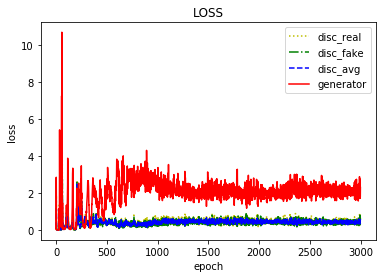

In [11]:
# 손실 그래프
import numpy as np
import matplotlib.pyplot as plt

epo = np.arange(0, epoch)

plt.figure()
plt.plot(epo, loss_disc_real,'y:',label='disc_real')
plt.plot(epo, loss_disc_fake,'g-.',label='disc_fake')
plt.plot(epo, loss_disc_avg,'b--',label='disc_avg')
plt.plot(epo, loss_gan,'r',label='generator')
plt.title('LOSS')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

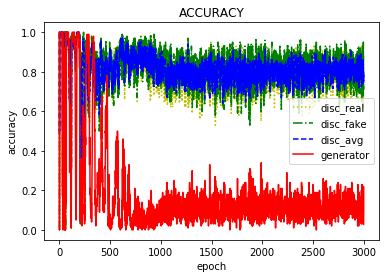

In [12]:
# 정확도 그래프
plt.figure()
plt.plot(epo, acc_disc_real,'y:',label='disc_real')
plt.plot(epo, acc_disc_fake,'g-.',label='disc_fake')
plt.plot(epo, acc_disc_avg,'b--',label='disc_avg')
plt.plot(epo, acc_gan,'r',label='generator')
plt.title('ACCURACY')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

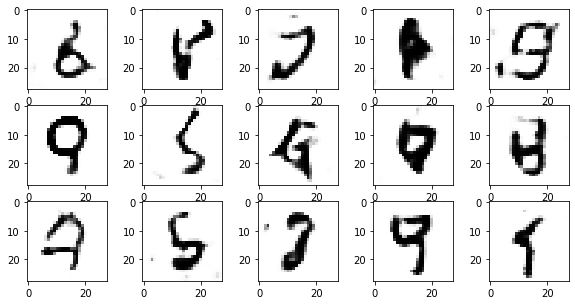

In [13]:
# epoch=3000
import matplotlib.pyplot as plt
gen_imgs = 0.5 * gen_imgs + 0.5
plt.figure(figsize=(10, 5))
for i in range(3*5):
    plt.subplot(3, 5, i+1)
    plt.imshow(gen_imgs[i].reshape((28, 28)), cmap='Greys')
plt.show()

In [14]:
loss_disc_real

[0.6043525,
 0.00082763226,
 0.011677215,
 1.875382,
 0.0031071403,
 2.3865658e-05,
 8.916897e-07,
 7.092968e-08,
 1.5616538e-07,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 8.1062645e-08,
 0.0,
 0.0,
 0.0,
 8.82152e-08,
 0.0,
 9.972159e-07,
 9.928557e-06,
 6.942801e-05,
 0.16421555,
 0.03736746,
 0.53320575,
 0.54865897,
 1.4267294,
 0.019259514,
 0.08864632,
 0.26175576,
 0.046654038,
 0.0018871606,
 0.0005077563,
 0.0009856622,
 0.009891694,
 0.38722724,
 0.8142378,
 0.5510209,
 0.26496994,
 0.032432944,
 0.0023417815,
 0.0004328749,
 2.3269002e-05,
 0.00012880714,
 2.7454712e-06,
 1.720566e-05,
 0.00016799594,
 0.01401295,
 0.6683187,
 2.067233,
 0.0730558,
 7.163661,
 0.08365615,
 0.2545078,
 4.633043,
 0.14051758,
 0.058757376,
 0.52888405,
 0.9178608,
 0.20505682,
 0.041210905,
 0.016061235,
 0.013001554,
 0.015045241,
 0.053905096,
 0.05233208,
 0.10295825,
 0.04389483,
 0.039244756,
 0.033074662,
 0.032444846,
 0.021577824,
 0.03978992,
 0.017914698,
 0.

In [16]:
loss_disc_fake

[1.1281263,
 1.1781977,
 0.50657755,
 0.3835868,
 0.38291347,
 0.24594928,
 0.11733662,
 0.04226034,
 0.015579342,
 0.0036181607,
 0.0016819447,
 0.000784969,
 0.0004527442,
 0.0037638256,
 0.00068871287,
 0.00055817905,
 0.0013425043,
 0.0006174349,
 0.0008891174,
 0.0032004088,
 0.02914816,
 0.0106264,
 0.013463745,
 0.009989648,
 0.027133457,
 0.010988945,
 0.05054309,
 0.01735599,
 0.07051388,
 0.18152645,
 0.31609395,
 0.45489487,
 1.050983,
 0.5866606,
 0.22467977,
 0.004046257,
 0.0022457936,
 0.014297184,
 0.09752076,
 0.18092917,
 0.22091205,
 0.22559302,
 0.6395213,
 1.8659787,
 0.5927346,
 0.009026101,
 0.00046162232,
 0.00012622474,
 4.6329253e-05,
 2.5570465e-05,
 0.00024263954,
 0.0016764737,
 0.04469226,
 0.1181642,
 0.0041715167,
 3.7567585,
 0.2886,
 2.1499894,
 0.09835803,
 6.6052175,
 0.10059729,
 0.16639882,
 2.815449,
 0.5075486,
 0.03503017,
 0.029961878,
 0.11775483,
 0.24366575,
 0.22600548,
 0.13935688,
 0.0751533,
 0.03052847,
 0.012412044,
 0.011074428,
 0.01

In [15]:
acc_disc_real

[0.97,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.96,
 0.97,
 0.85,
 0.79,
 0.38,
 1.0,
 1.0,
 0.87,
 0.99,
 1.0,
 1.0,
 1.0,
 1.0,
 0.87,
 0.72,
 0.83,
 0.86,
 0.98,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.73,
 0.31,
 0.97,
 0.0,
 0.98,
 0.92,
 0.0,
 0.95,
 0.99,
 0.76,
 0.51,
 0.92,
 1.0,
 1.0,
 1.0,
 1.0,
 0.98,
 0.98,
 0.96,
 0.98,
 1.0,
 0.98,
 0.98,
 1.0,
 0.99,
 0.99,
 0.99,
 0.99,
 1.0,
 0.96,
 0.98,
 0.91,
 0.96,
 0.95,
 0.99,
 0.95,
 0.91,
 0.88,
 0.94,
 0.89,
 0.9,
 0.87,
 0.78,
 0.86,
 0.7,
 0.68,
 0.75,
 0.74,
 0.58,
 0.63,
 0.78,
 0.7,
 0.91,
 0.92,
 0.95,
 0.91,
 0.95,
 0.95,
 0.88,
 0.83,
 0.81,
 0.67,
 0.53,
 0.35,
 0.33,
 0.52,
 0.61,
 0.83,
 0.92,
 0.95,
 0.89,
 0.92,
 0.97,
 0.92,
 1.0,
 0.99,
 0.97,
 0.95,
 0.97,
 0.97,
 0.96,
 0.98,
 0.95,
 0.97,
 0.99,
 0.97,
 0.95,
 0.93,
 0.94,
 0.93,
 0.96,
 0.93,
 0.99,
 0.9,
 0.92,
 0.97,

In [17]:
acc_disc_fake

[0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.99,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.99,
 1.0,
 0.99,
 1.0,
 1.0,
 1.0,
 0.99,
 1.0,
 0.98,
 0.92,
 0.84,
 0.78,
 0.22,
 0.8,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.97,
 0.92,
 0.91,
 0.67,
 0.35,
 0.72,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.99,
 0.96,
 1.0,
 0.03,
 0.91,
 0.06,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.78,
 1.0,
 1.0,
 0.98,
 0.97,
 0.96,
 0.96,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.99,
 0.99,
 1.0,
 0.99,
 0.99,
 1.0,
 1.0,
 0.99,
 0.97,
 0.97,
 0.97,
 0.95,
 0.93,
 0.97,
 0.91,
 0.96,
 0.92,
 0.95,
 0.85,
 0.83,
 0.82,
 0.82,
 0.65,
 0.74,
 0.8,
 0.71,
 0.56,
 0.8,
 0.85,
 0.94,
 0.92,
 0.97,
 0.93,
 0.91,
 0.96,
 0.98,
 0.66,
 0.91,
 0.58,
 0.34,
 0.58,
 0.3,
 0.75,
 0.81,
 0.8,
 0.92,
 0.99,
 0.98,
 0.93,
 0.97,
 0.97,
 0.98,
 0.99,
 0.97,
 0.97,
 0.99,
 0.99,
 0.96,
 0.99,
 0.98,
 0.96,
 0.95,
 0.93,
 0.96,
 0.96,
 0.94,
 0.99,
 1.0,
 0.92,
 0.95,
 0.94,
 0.91,
 0.97,
 0.9

# 전체 코드

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Reshape, Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, LeakyReLU

import matplotlib.pyplot as plt

# 랜덤 시드 설정
np.random.seed(0)
tf.random.set_seed(0)

# 데이터 불러오기
(X_raw, _), (_, _) = mnist.load_data()

# 변수 설정
n_img = X_raw.shape[0]
epoch = 3000
n_batch = 100

# 데이터 전처리
X_re = X_raw.reshape(n_img, 28, 28, 1)
scale_c = 255/2
X = (X_re - scale_c) / scale_c
real_1 = np.ones((n_batch, 1))
fake_0 = np.zeros((n_batch, 1))

# 생성자
input_layer1 = Input(shape=(100,))
x1 = Dense(64*7*7)(input_layer1)
x1 = BatchNormalization()(x1)
x1 = Activation(LeakyReLU(0.3))(x1)
x1 = Reshape((7,7,64))(x1)
x1 = UpSampling2D()(x1)
x1 = Conv2D(32, kernel_size=(3,3), padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = Activation(LeakyReLU(0.3))(x1)
x1 = UpSampling2D()(x1)
output_layer1 = Conv2D(1, kernel_size=(3,3), padding='same', activation='tanh')(x1)
generator = Model(input_layer1, output_layer1)
generator.summary()

# 판별자
input_layer2 = Input(shape=(28, 28, 1))
x2 = Conv2D(64, kernel_size=(5,5), padding='same')(input_layer2)
x2 = Activation(LeakyReLU(0.3))(x2)
x2 = Dropout(0.25)(x2)
x2 = Conv2D(128, kernel_size=(3,3), padding='same')(x2)
x2 = Activation(LeakyReLU(0.3))(x2)
x2 = Dropout(0.25)(x2)
x2 = Flatten()(x2)
output_layer2 = Dense(1, activation='sigmoid')(x2)
discriminator = Model(input_layer2, output_layer2)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.trainable = False
discriminator.summary()

# GAN
input_gan = Input(shape=(100,))
output_dis = discriminator(generator(input_gan))
gan = Model(input_gan, output_dis)
gan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gan.summary()

# 학습
loss_disc_real = [0]*epoch
loss_disc_fake = [0]*epoch
loss_disc_avg = [0]*epoch
loss_gan = [0]*epoch
acc_disc_real = [0]*epoch
acc_disc_fake = [0]*epoch
acc_disc_avg = [0]*epoch
acc_gan = [0]*epoch

for i in range(0, epoch):
    # 실제 데이터 판별
    idx = np.random.randint(0, n_img, n_batch)
    imgs = X[idx]
    res_real = discriminator.train_on_batch(imgs, real_1)
    
    # 가짜 데이터 생성 및 판별
    fake = np.random.normal(0, 1, size=(n_batch, 100))
    gen_imgs = generator.predict(fake)
    res_fake = discriminator.train_on_batch(gen_imgs, fake_0)
    
    # 판별 손실 평균 & 정확도 평균
    loss_disc_avg_ith = np.add(res_real[0],res_fake[0])*0.5
    acc_disc_avg_ith = np.add(res_real[1],res_fake[1])*0.5
    
    # GAN 결과
    res_gan = gan.train_on_batch(fake, real_1)

    # 정확도 및 손실
    loss_disc_real[i] = res_real[0]
    loss_disc_fake[i] = res_fake[0]
    loss_disc_avg[i] = loss_disc_avg_ith
    loss_gan[i] = res_gan[0]
    
    acc_disc_real[i] = res_real[1]
    acc_disc_fake[i] = res_fake[1]
    acc_disc_avg[i] = acc_disc_avg_ith
    acc_gan[i] = res_gan[1]
    
    print('epoch:%d'%i,
          ' 판별손실평균:%.4f'%loss_disc_avg_ith,
          ' 판별정확도평균:%.4f'%acc_disc_avg_ith,
          ' 생성손실:%.4f'%res_gan[0], 
          ' 생성정확도:%.4f'%res_gan[1])

# 손실 그래프
epo = np.arange(0, epoch)

plt.figure()
plt.plot(epo, loss_disc_real,'y:',label='disc_real')
plt.plot(epo, loss_disc_fake,'g-.',label='disc_fake')
plt.plot(epo, loss_disc_avg,'b--',label='disc_avg')
plt.plot(epo, loss_gan,'r',label='generator')
plt.title('LOSS')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


# 정확도 그래프
plt.figure()
plt.plot(epo, acc_disc_real,'y:',label='disc_real')
plt.plot(epo, acc_disc_fake,'g-.',label='disc_fake')
plt.plot(epo, acc_disc_avg,'b--',label='disc_avg')
plt.plot(epo, acc_gan,'r',label='generator')
plt.title('ACCURACY')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()


# epoch=3000
gen_imgs = 0.5 * gen_imgs + 0.5
plt.figure(figsize=(10, 5))
for i in range(3*5):
    plt.subplot(3, 5, i+1)
    plt.imshow(gen_imgs[i].reshape((28, 28)), cmap='Greys')
plt.show()